# Packages

In [63]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
import time
import matplotlib.pyplot as plt
import copy
import os
import seaborn as sns
import pickle as pkl

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Utilities

In [64]:
class MCElbo(torch.nn.Module):
    def __init__(self, nMC, x_dim, N):
        """Note, the fact that we need to include N and S now is not the most flexible, 
            however, it will save time since each iterration of the update will not have to compute these"""
        super(MCElbo, self).__init__()
        
        self.nMC = nMC
        self.x_dim = x_dim
        self.param_dim = 1 + 1 + 1 + x_dim #sigma2, eta_d, beta_d
        self.softplus = torch.nn.Softplus() # transformation of the variable
        self.N = N
        
        self.up_exp_d_a, self.up_exp_d_b = np.triu_indices(N, 1)
        
        ### Parameters for the variational posterior
        # Mean parameters for the GP's
        
        self.q_beta_d_m = torch.nn.Parameter(torch.randn(1,1))
        self.q_beta_d_s = torch.nn.Parameter(torch.randn(1,1))
        
        # Thetas
        
        # Variance
        self.q_sigma2_m = torch.nn.Parameter(torch.randn(1,1))
        self.q_sigma2_s = torch.nn.Parameter(torch.randn(1,1))
        
        # Scales of the kernels
        
        self.q_eta_d_m = torch.nn.Parameter(torch.randn(1,1))
        self.q_eta_d_s = torch.nn.Parameter(torch.randn(1,1))
        
        # Length scale for the kernels
        
        self.q_ls_d_m = torch.nn.Parameter(torch.randn(1,x_dim)) 
        self.q_ls_d_s = torch.nn.Parameter(torch.randn(1,x_dim)) 
        
        ### Prior distributions
        
        self.prior_beta_d_m = torch.randn(1,1)
        self.prior_beta_d_s = torch.randn(1,1)
        
        
        self.prior_sigma2_m = torch.randn(1,1)
        self.prior_sigma2_s = torch.randn(1,1)
        
        
        self.prior_eta_d_m = torch.randn(1,1)
        self.prior_eta_d_s = torch.randn(1,1)
        
        
        self.prior_ls_d_m = torch.randn(1,x_dim) # To be changed for x_dim +  theta_dim
        self.prior_ls_d_s = torch.randn(1,x_dim) # To be changed for x_dim +  theta_dim
        
        
        # Set appropriate values for prior likelihoods

        self.prior_beta_d_m.data.fill_(0)
        self.prior_beta_d_s.data.fill_(1)
        
        self.prior_sigma2_m.data.fill_(1)
        self.prior_sigma2_s.data.fill_(np.sqrt(np.log(2)))
        
        self.prior_eta_d_m.data.fill_(1)
        self.prior_eta_d_s.data.fill_(np.sqrt(np.log(2)))
        
        self.prior_ls_d_m.data.fill_(1)
        self.prior_ls_d_s.data.fill_(np.sqrt(np.log(2)))
        
        
        ### Current parameter state holder holder
        self.beta_d = torch.FloatTensor((1))
        self.beta_d.data.fill_(1)
        self.likelihood_s = torch.FloatTensor((1))
        self.likelihood_s.data.fill_(1)
        self.eta_d = torch.FloatTensor((1))
        self.eta_d.data.fill_(1)
        self.ls_d = torch.randn(1,x_dim)
        self.ls_d.data.fill_(1)
        
    def log_LogNormal(self, param, m, s):
        """Computes log likelihood of log_normal density
        Args:
            param: 1 X K dimensional tensor
            m: 1 X K dimensional mean tensor
            s: 1 X K dimensional std tensor
        """
        interm__ = ((torch.log(param) - m) / s).pow(2)
        log_prob = - len(param) * np.log(2 * np.pi) / 2 - torch.log(param).sum() - torch.log(s).sum() - 0.5 * interm__.sum()
        return log_prob.reshape(1,1)
    
    def log_Normal(self, param, m, s):
        """Computes log likelihood of log_normal density
        Args:
            param: 1 X K dimensional tensor
            m: 1 X K dimensional mean tensor
            s: 1 X K dimensional std tensor
        """
        interm__ = ((param - m) / s).pow(2)
        log_prob = - len(param) * np.log(2 * np.pi) / 2 - torch.log(s).sum() - 0.5 * interm__.sum()
        return log_prob.reshape(1,1)
        
    def q_log(self):
        # The normal distributions for thetas need to be updated
        log_lkl = self.log_Normal(self.beta_d, self.q_beta_d_m, self.softplus(self.q_beta_d_s)) + \
        self.log_LogNormal(self.likelihood_s, self.q_sigma2_m, self.softplus(self.q_sigma2_s)) + \
        self.log_LogNormal(self.eta_d, self.q_eta_d_m, self.softplus(self.q_eta_d_s)) + \
        self.log_LogNormal(self.ls_d, self.q_ls_d_m, self.softplus(self.q_ls_d_s))
        return log_lkl
    
    def pri_log(self):
        # The normal distributions for thetas need to be updated
        log_lkl = self.log_Normal(self.beta_d, self.prior_beta_d_m, self.prior_beta_d_s) + \
        self.log_LogNormal(self.likelihood_s, self.prior_sigma2_m, self.softplus(self.prior_sigma2_s)) + \
        self.log_LogNormal(self.eta_d, self.prior_eta_d_m, self.softplus(self.prior_eta_d_s)) + \
        self.log_LogNormal(self.ls_d, self.prior_ls_d_m, self.softplus(self.prior_ls_d_s))
        return log_lkl
    
        
    def generate_sample(self, n_var = 2):
        return Normal(0,1).sample((self.nMC,n_var,1))
    
    def sample_reparam_normal(self, param, m, s):
        return param.mul(self.softplus(s.T)).add(m.T)
    
    def sample_reparam_logNormal(self, param, m, s):
        return torch.exp(param.mul(self.softplus(s.T)).add(m.T))
    
    def RBFkernel(self, x, length_scale, eta, a, b):
        """
        Note, since length_scale will be a sample, I will need to pass length_scale.T
        Args:
            x: Input tensor of dimensions N x D
            lenght_scale: Tenosr of lengthscales with dimension 1 X D, if 1 X 1 then common ls
            a, b: Tuple output from numpy.triu_indices(N) - this is for time saving purposes
            eta: Tensor 1 X 1 containing the kernel scale
        """
        # Prep for the kernel computation
        M = len(x)
        W__ = torch.ones((M, M))

        condensed_dist_mat = torch.exp( -0.5 * (torch.nn.functional.pdist(x / length_scale, p = 2).pow(2)))
        W__[a,b] = condensed_dist_mat
        W__[b,a] = condensed_dist_mat
        return W__.mul(eta)
        
    def forward(self,x):
        """Returns dat likelihood for one MC sample"""
        d_cov_mat = self.RBFkernel(x, self.ls_d, self.eta_d, self.up_exp_d_a, self.up_exp_d_b)
        # Noise kernel
        noise_cov_mat = torch.diag(torch.ones(self.N)) * self.likelihood_s
        cov_mat = d_cov_mat + noise_cov_mat
        
        # Likelihood means
        mean_vec = torch.ones((self.N, 1), dtype = torch.float) * self.beta_d
        
        return torch.distributions.multivariate_normal.MultivariateNormal(mean_vec.flatten(), cov_mat)
    
    def compute_elbo_loop(self, x, y):     
        
        z = self.generate_sample(n_var = self.param_dim)
        sigma2 = self.sample_reparam_logNormal(z[:, 0], self.q_sigma2_m, self.q_sigma2_s)
        beta_d = self.sample_reparam_normal(z[:, 1], self.q_beta_d_m, self.q_beta_d_s)
        eta_d = self.sample_reparam_logNormal(z[:, 2], self.q_eta_d_m, self.q_eta_d_s)
        ls_d = self.sample_reparam_logNormal(z[:, 3:(3 + self.x_dim)], self.q_ls_d_m, self.q_ls_d_s)

        loss = torch.randn(1,1)
        loss.data.fill_(0.0)
        
        for i in range(self.nMC):
            self.likelihood_s = sigma2[i]
            self.eta_d = eta_d[i]
            self.beta_d = beta_d[i]
            self.ls_d = ls_d[i].T
            
            q_likelihood = self.q_log()
            prior_likelihood = self.pri_log()
            data_likelihood = self.forward(x).log_prob(y)
        
            loss += data_likelihood + prior_likelihood - q_likelihood
        return loss / self.nMC
    
    def ModelString(self):
        return f"beta mean: {self.q_beta_d_m} , sigma^2 mean: {torch.exp(self.q_sigma2_m + 0.5 * self.softplus(self.q_sigma2_s) ** 2).item()}"

# AME preprocessing

In [92]:
# AME2003
masses03 = pd.read_fwf('mass.mas03', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)
masses03['avEbind'] = pd.to_numeric(masses03['avEbind'], errors='coerce')
masses03 = masses03.dropna()
masses03 = masses03.drop(0)
masses03['BE_per_A'] = masses03['avEbind'] / 1000
masses03['AME2003'] = masses03['BE_per_A'] * masses03['A']
masses03["S2n_03"] = np.nan
masses03 = masses03.drop(columns = ['avEbind', 'BE_per_A'])

In [93]:
for index, row in masses03.iterrows():
    if np.any((masses03["N"] == (row["N"] - 2)) & (masses03["Z"] == row["Z"])):
        masses03.loc[(masses03["N"] == (row["N"])) & (masses03["Z"] == row["Z"]), "S2n_03"] = masses03[(masses03["N"] == (row["N"])) & (masses03["Z"] == row["Z"])]["AME2003"].squeeze()  -  masses03[(masses03["N"] == (row["N"] - 2)) & (masses03["Z"] == row["Z"])]["AME2003"].squeeze()  
masses03 = masses03.dropna()
masses03 =  masses03.loc[(masses03["N"] % 2) == 0,]
masses03 = masses03.loc[masses03["Z"] > 1]

In [94]:
# AME2016
masses16 = pd.read_fwf('mass16.txt', usecols=(2,3,4,11),
              names=('N', 'Z', 'A', 'avEbind'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)
masses16['avEbind'] = pd.to_numeric(masses16['avEbind'], errors='coerce')
masses16 = masses16.dropna()
masses16 = masses16.drop(0)
masses16['BE_per_A'] = masses16['avEbind'] / 1000
masses16['AME2016'] = masses16['BE_per_A'] * masses16['A']
masses16["S2n_16"] = np.nan
masses16 = masses16.drop(columns = ['avEbind', 'BE_per_A'])

In [95]:
for index, row in masses16.iterrows():
    if np.any((masses16["N"] == (row["N"] - 2)) & (masses16["Z"] == row["Z"])):
        masses16.loc[(masses16["N"] == (row["N"])) & (masses16["Z"] == row["Z"]), "S2n_16"] = masses16[(masses16["N"] == (row["N"])) & (masses16["Z"] == row["Z"])]["AME2016"].squeeze()  -  masses16[(masses16["N"] == (row["N"] - 2)) & (masses16["Z"] == row["Z"])]["AME2016"].squeeze()  
masses16 = masses16.dropna()
masses16 =  masses16.loc[(masses16["N"] % 2) == 0,]
masses16 = masses16.loc[masses16["Z"] > 1]

In [96]:
masses_merge = pd.merge(masses16, masses03, on = ["N", "Z", "A"], how = "left")
print(masses_merge)

        N    Z    A      AME2016     S2n_16      AME2003     S2n_03
0       4    2    6    29.271114   0.975454    29.268102   0.972442
1       4    3    7    39.245073  12.914413    39.244037  12.913377
2       6    2    8    31.396160   2.125046    31.407800   2.139698
3       4    4    8    56.499480  29.575998    56.499480  29.575908
4       6    3    9    45.339912   6.094839    45.340551   6.096514
...   ...  ...  ...          ...        ...          ...        ...
1148  154  102  256  1898.635776  13.043916  1898.633984  13.043140
1149  156  101  257  1906.318574  11.992679  1906.315233  11.989338
1150  154  104  258  1904.694804  14.023700          NaN        NaN
1151  156  106  262  1923.390470  14.324350          NaN        NaN
1152  158  108  266  1941.340618  14.569618          NaN        NaN

[1153 rows x 7 columns]


In [97]:
# Adding model evaluations
exp = ['exp']
models = ['SKM*', 'SKP', 'SLY4', 'SVMIN', 'UNEDF0', 'UNEDF1']
xls = pd.ExcelFile('separations_energies_NEW2018.xls')
#xls = pd.ExcelFile('separations_energies_AME2003.xls')
data_raw = pd.read_excel(xls, header=[0,3], sheet_name = 'S2n')

In [98]:
data_raw_sub = data_raw.T.loc[[('-', 'Z'), ('-', 'N'), ('exp', 'measure'), ('exp', 'sd'), (models[0], 'mean'), (models[1], 'mean'),
               (models[2], 'mean'),(models[3], 'mean'),(models[4], 'mean'),(models[5], 'mean')]].T
data_raw_sub.columns = ['_'.join(col) for col in data_raw_sub.columns.values]
data_raw_sub.columns = ['Z', 'N'] + ['exp'] + ['sd'] + models
is_na = data_raw_sub[['exp'] + models].notna()
is_na = is_na.all(axis = 1)
data_raw_sub = data_raw_sub[is_na]
data_raw_sub = data_raw_sub.rename(columns={'SKM*': 'SKM'})

In [99]:
# This is the final complete set of separation energies to be used for training and testing
S2n = pd.merge(data_raw_sub, masses_merge, on = ["N", "Z"], how = "left")
print(S2n)

        Z    N      exp       sd      SKM      SKP      SLY4    SVMIN  \
0       2    4  0.97545    5e-05  7.16891  6.17571   5.43824  3.98792   
1       2    6  2.12505   0.0001  2.54031  0.97832  0.402399  1.44276   
2       3    4  12.9144     0.05  14.9108  14.8107   14.1642  12.0455   
3       3    6  6.09484  0.00019  9.23278  7.94095   7.75287  8.18013   
4       3    8  0.36928  0.00064  2.20105  1.52635    1.5789  2.72982   
...   ...  ...      ...      ...      ...      ...       ...      ...   
1156  102  152  14.2907  0.01337  14.4744  13.7689   13.3826  13.8442   
1157  102  154  13.0439  0.01232  13.4624  13.2137   12.3785  13.0527   
1158  104  154  14.0236   0.0366  14.4146  14.1158   13.3347  13.9626   
1159  106  156  14.3244  0.04092  14.7752  14.4959   13.7949  14.2829   
1160  108  158  14.5695  0.04828  15.5506  14.8156   14.5353  14.8307   

        UNEDF0   UNEDF1      A      AME2016     S2n_16      AME2003     S2n_03  
0       5.2988  4.53857    6.0    29.27111

In [100]:
# Final training and testing set of S2n observations
S2n_test = S2n[S2n['S2n_03'].isna()]
S2n_train = S2n[np.invert(S2n['S2n_03'].isna())]
S2n_test = S2n_test[np.invert(S2n_test["S2n_16"].isna())]

In [101]:
S2n_test

,Z,N,exp,sd,SKM,SKP,SLY4,SVMIN,UNEDF0,UNEDF1,A,AME2016,S2n_16,AME2003,S2n_03
14,5,14,0.08871,0.56362,3.09594,0.983308,0.484686,1.24547,1.14065,0.91115,19.0,89.673046,0.088707,NaN,NaN
21,6,16,0.035,0.02,3.37334,1.3939,1.25564,2.00023,1.94645,1.85528,22.0,119.263694,0.034994,NaN,NaN
27,7,16,4.65412,0.44142,5.98846,4.3354,4.141,4.63265,4.54357,4.40957,23.0,143.443433,4.654118,NaN,NaN
40,9,20,1.44273,0.6542,2.40393,1.63955,1.74643,2.24543,2.2461,1.66967,29.0,186.876899,1.442735,NaN,NaN
48,11,8,38.3865,1.00141,36.0828,37.4923,38.4369,37.5689,36.6198,39.5784,19.0,131.819815,38.386455,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,96,142,14.5525,0.02198,15.1495,14.497,14.3289,14.5526,14.4385,14.3383,238.0,1796.423048,14.552484,NaN,NaN
1140,98,144,14.7466,0.02267,15.5253,14.8588,14.5387,14.8458,14.7944,14.5828,242.0,1817.201716,14.746516,NaN,NaN
1158,104,154,14.0236,0.0366,14.4146,14.1158,13.3347,13.9626,14.0512,13.6757,258.0,1904.694804,14.023700,NaN,NaN
1159,106,156,14.3244,0.04092,14.7752,14.4959,13.7949,14.2829,14.4046,13.9638,262.0,1923.390470,14.324350,NaN,NaN


### Plotting the data

In [61]:
# Plotting data
Z_range =[0, 110]
N_range = [0, 160]

Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 2) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 2) + 1, endpoint=True)

residuals = np.zeros((len(Zs), len(Ns)))

#Training data
for i in range(len(Zs)):
    for j in range(len(Ns)):
        fltr = (S2n_train["Z"] == Zs[i]) & (S2n_train["N"] == Ns[j])
        row = S2n_train[fltr]
        if row.empty != True:
            #residuals[i,j] = float(row['Residuals'])
            residuals[i,j] = float(1)
            
#Testing data
for i in range(len(Zs)):
    for j in range(len(Ns)):
        fltr = (S2n_test["Z"] == Zs[i]) & (S2n_test["N"] == Ns[j])
        row = S2n_test[fltr]
        if row.empty != True:
            #residuals[i,j] = float(row['Residuals'])
            residuals[i,j] = float(2)

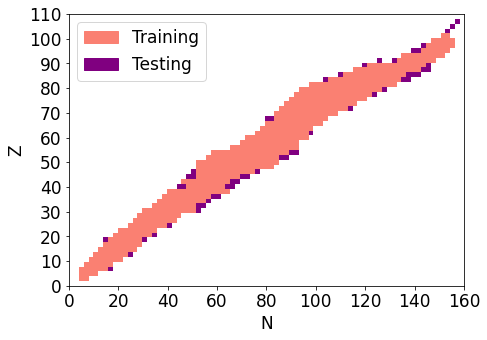

In [62]:
cmap = ListedColormap(['white','salmon', 'purple'])
Z_range =[0, 110]
N_range = [0, 160]
Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 20) + 1, endpoint=True)
fig = plt.figure(figsize=(8, 5)) 
plt.rcParams.update({'font.size': 17})
extent=(0,160,0,110)
plt.imshow(np.flip(residuals, axis = 0), extent=extent, cmap=cmap)
plt.xticks(Ns.astype(int))
plt.yticks(np.flip(Zs.astype(int)))
plt.ylabel('Z')
plt.xlabel('N')

# Legend Part
labels = ["Training", "Testing"]
colors = ['salmon', 'purple']
patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in range(2)]

plt.legend(handles=patches, loc = 'upper left')
plt.savefig('Nuclear_domain.pdf',dpi=500,bbox_inches='tight')
plt.show()

# Fitting single GPS

In [102]:
model_name = "UNEDF1"
torch.manual_seed(2)
residuals = S2n_train["S2n_16"] - S2n_train[model_name]
x_train = torch.tensor(S2n_train[["Z", "N"]].to_numpy(float), dtype = torch.float)
y_train = torch.tensor(residuals.to_numpy(float).flatten(), dtype = torch.float)
model = MCElbo(nMC= 10, x_dim = x_train.shape[1], N = x_train.shape[0])

learning_rate = 5e-2
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
n_steps = 300

loss_array = np.zeros(n_steps)
time_array = np.zeros(n_steps)
param_dictionary = {}

for name, param in model.named_parameters():
    param_dictionary[name] = []
    
startTime = time.time()
for t in range(n_steps):
    # Compute prediction
    loss = - model.compute_elbo_loop(x_train, y_train)
    # Compute loss
    # Zero gradinets
    optimizer.zero_grad()
    # Compute gradients
    loss.backward()
    optimizer.step()
    loss_array[t] = loss.item()
    time_array[t] = time.time() - startTime
    
    if t % 5 == 4: 
        for name, param in model.named_parameters():
            param_dictionary[name] = param_dictionary[name] + [param.detach().clone().numpy()]
    
    if t % 20 == 19:
        print(f"Loss: {loss.item()}, Step [{t}/{n_steps}]")
        print(model.ModelString())
        # Time estimmate
        print(f"Minutes remaining {(time.time() - startTime) * (n_steps - t) / (t * 60)}")
        
endTime = time.time()
print(endTime - startTime)

folder = "Masses_RMS_" + model_name

if not os.path.exists(folder):
    os.makedirs(folder)

## Saving Model State Dictionary
torch.save(model.state_dict(), folder + "\model_state_"  +".pth")
## Saving Optimizer State Dictionary
torch.save(optimizer.state_dict(), folder + "\optimizer_state_"  +".pth")
## Saving Parameters, Time, and Loss arrays
dictionary_outputs = copy.deepcopy(param_dictionary)
dictionary_outputs["ELBO"] = -loss_array
dictionary_outputs["time"] = time_array
with open(folder + "\outputs_" + "vars_" + '.pickle', 'wb') as handle:
    pkl.dump(dictionary_outputs, handle, protocol=pkl.HIGHEST_PROTOCOL)

Loss: 971.8565673828125, Step [19/300]
beta mean: Parameter containing:
tensor([[0.3129]], requires_grad=True) , sigma^2 mean: 0.1763564795255661
Minutes remaining 31.10643870579569
Loss: 821.7271728515625, Step [39/300]
beta mean: Parameter containing:
tensor([[0.2232]], requires_grad=True) , sigma^2 mean: 0.04043590649962425
Minutes remaining 28.049479088416465
Loss: 815.1678466796875, Step [59/300]
beta mean: Parameter containing:
tensor([[0.2345]], requires_grad=True) , sigma^2 mean: 0.028477052226662636
Minutes remaining 25.052574616434885
Loss: 825.71337890625, Step [79/300]
beta mean: Parameter containing:
tensor([[0.2592]], requires_grad=True) , sigma^2 mean: 0.022845758125185966
Minutes remaining 22.394073906477995
Loss: 814.0117797851562, Step [99/300]
beta mean: Parameter containing:
tensor([[0.2642]], requires_grad=True) , sigma^2 mean: 0.02116517350077629
Minutes remaining 19.70352698335744
Loss: 811.537841796875, Step [119/300]
beta mean: Parameter containing:
tensor([[0.

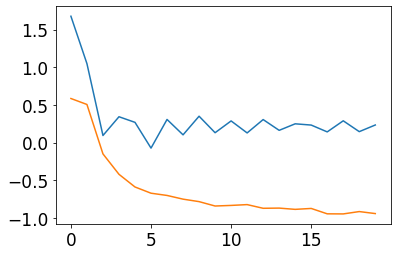

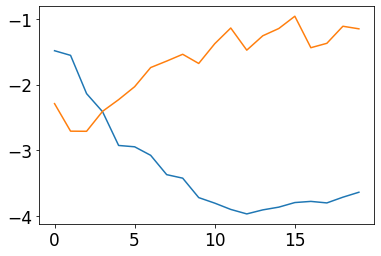

In [81]:
plt.plot(np.array(param_dictionary['q_ls_d_m']).reshape((len(np.array(param_dictionary['q_ls_d_m'])), 2)))
plt.show()
plt.plot(np.array(param_dictionary['q_ls_d_s']).reshape((len(np.array(param_dictionary['q_ls_d_s'])), 2)))
plt.show()

In [107]:
# Printing posterior distributions
model.nMC = 100000
z = model.generate_sample(n_var = model.param_dim)
sigma2 = model.sample_reparam_logNormal(z[:, 0], model.q_sigma2_m, model.q_sigma2_s)
beta_d = model.sample_reparam_normal(z[:, 1], model.q_beta_d_m, model.q_beta_d_s)
eta_d = model.sample_reparam_logNormal(z[:, 2], model.q_eta_d_m, model.q_eta_d_s)
ls_d = model.sample_reparam_logNormal(z[:, 3:(3 + model.x_dim)], model.q_ls_d_m, model.q_ls_d_s)

<AxesSubplot:ylabel='Count'>

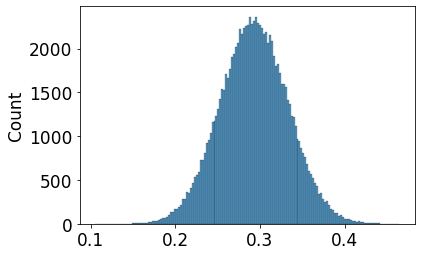

In [83]:
sns.histplot(beta_d.squeeze().detach().numpy())

<AxesSubplot:ylabel='Count'>

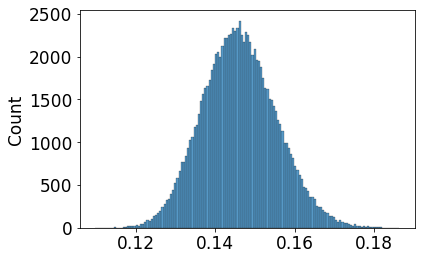

In [84]:
sns.histplot(np.sqrt(sigma2.squeeze().detach().numpy()))

In [108]:
# Posterior samples dictionary
posteriors_dictionary_sample = {}
posteriors_dictionary_sample['sigma'] = np.sqrt(sigma2.squeeze().detach().numpy())
posteriors_dictionary_sample['sigma2'] = sigma2.squeeze().detach().numpy()
posteriors_dictionary_sample['ls'] = ls_d.squeeze().detach().numpy()
posteriors_dictionary_sample['beta'] = beta_d.squeeze().detach().numpy()
posteriors_dictionary_sample['eta'] = eta_d.squeeze().detach().numpy()
with open(folder + "\posterior_samples" + '.pickle', 'wb') as handle:
    pkl.dump(posteriors_dictionary_sample, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [57]:
posteriors_dictionary_sample['ls']

array([[1.2048815 , 0.36792758],
       [1.1836001 , 0.6617339 ],
       [1.2580775 , 0.2901921 ],
       ...,
       [1.2099622 , 0.46044743],
       [1.2500861 , 0.43205118],
       [1.2260642 , 0.28720143]], dtype=float32)

# Loading simple average

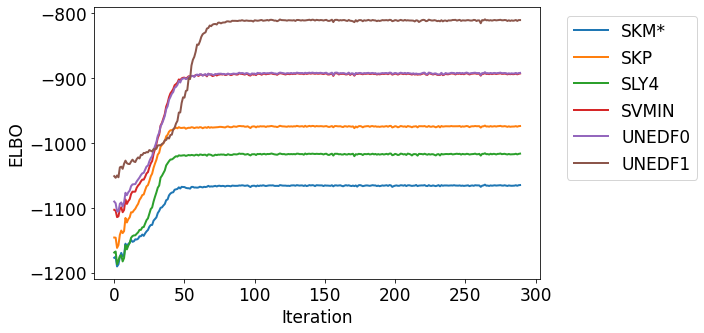

[-1065.78798584  -974.51140991 -1017.36243347  -893.51800293
  -892.52681702  -810.93091858]
[nan nan nan nan nan nan]


C:\Users\Vojtech\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [89]:
# Loading saved data and computing model weights
model_space = ['SKM', 'SKP', 'SLY4', 'SVMIN', 'UNEDF0', 'UNEDF1']
ELBO_dictionary ={}
ELBO_average = np.zeros(len(model_space))
fig = plt.figure(figsize=(8, 5)) 
lw = 2
plt.rcParams.update({'font.size': 17})
for i in range(len(model_space)):
    folder = "Masses_" + model_space[i]
    with open(folder + "\outputs_" + "vars_" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    ELBO_dictionary[str(i)] = dictionary_outputs["ELBO"]
    ELBO_average[i] = np.mean(dictionary_outputs["ELBO"][-100:])
    if model_space[i] != 'SKM':
        plt.plot(dictionary_outputs["ELBO"][10:], label =model_space[i], lw = lw )
    else:
        plt.plot(dictionary_outputs["ELBO"][10:], label ='SKM*' , lw = lw)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Nuclear_ELBO.pdf',dpi=500,bbox_inches='tight')
plt.show()

print(ELBO_average)
print(np.exp(ELBO_average) / np.sum(np.exp(ELBO_average)))

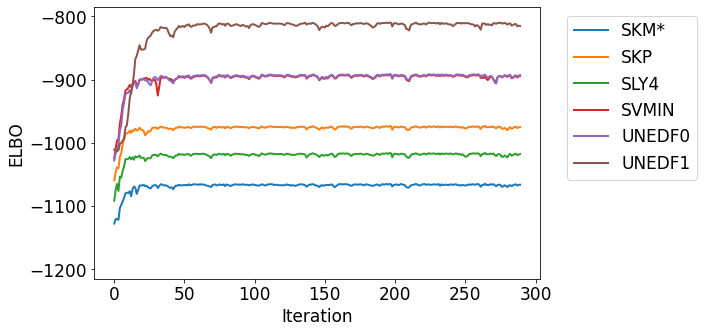

[-1066.51707031  -975.22774109 -1018.15772949  -894.74145203
  -893.70679688  -812.11951294]
[nan nan nan nan nan nan]


C:\Users\Vojtech\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [116]:
# Loading saved data and computing model weights
model_space = ['SKM', 'SKP', 'SLY4', 'SVMIN', 'UNEDF0', 'UNEDF1']
ELBO_dictionary ={}
ELBO_average = np.zeros(len(model_space))
fig = plt.figure(figsize=(8, 5)) 
lw = 2
plt.rcParams.update({'font.size': 17})
for i in range(len(model_space)):
    folder = "Masses_RMS_" + model_space[i]
    with open(folder + "\outputs" + '.pickle', 'rb') as handle:
        dictionary_outputs = pkl.load(handle)
    ELBO_dictionary[str(i)] = dictionary_outputs["ELBO"]
    ELBO_average[i] = np.mean(dictionary_outputs["ELBO"][-100:])
    if model_space[i] != 'SKM':
        plt.plot(dictionary_outputs["ELBO"][10:], label =model_space[i], lw = lw )
    else:
        plt.plot(dictionary_outputs["ELBO"][10:], label ='SKM*' , lw = lw)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.ylim([-1215,-785])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig('Nuclear_ELBO_RMS.pdf',dpi=500,bbox_inches='tight')
plt.show()

print(ELBO_average)
print(np.exp(ELBO_average) / np.sum(np.exp(ELBO_average)))